# Calculating band indices with Spyndex packages

* **Products used:** 
[ s2_l2a](https://explorer.digitalearth.africa/s2_l2a) 

## Background

The [Spyndex python package](https://www.nature.com/articles/s41597-023-02096-0) provides access to spectral indices from the Awesome Spectral Indices catalogue. This is a standardized, ready to use, curated list of spectral indices. The Spyndex package currently includes [232 optical and radar indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/spectral-indices-table.csv).

One of the benefits of this package is the large number of spectral indices which it makes available to Sandbox users for analysis without having to manually define indices in the notebooks.

## Description
This notebook demonstrates how to:
 
* Load dataset using `load_ard`
* Calculate NDVI and EVI indices using the `spyndex` function 
* Calculate NDVI and EVI indices using the `calculate_indices` function
* Plot the results from both functions
* Calculate and plot GNDVI and VARI using `spyndex` function

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
In addition to the existing packages, the spyndex package will be loaded by importing it. If the cell below returns an error, un-comment the installation line `!pip install spyndex` by removing the `#`.

In [1]:
#!pip install spyndex

In [2]:
# Load the python packages.
%matplotlib inline

import os

os.environ["USE_PYGEOS"] = "0"

import matplotlib.pyplot as plt
import geopandas as gpd

#import spyndex packages
import spyndex

import datacube

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb
from deafrica_tools.bandindices import calculate_indices
from datacube.utils.geometry import Geometry
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube
Connect to the datacube database to enable loading Digital Earth Africa data.

In [3]:
# Connect to the datacube
dc = datacube.Datacube(app="spyndex_function")

### Select location
Using the `define_area` function, select area of interest by specifying `lat`,`lon` and `buffer`. If you have the vector or shapefile uncomment the code below **Method 2** and replace the `aoi.shp` with the path of your  shapefile.

In [4]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=31.23394, lon=31.05560, buffer=0.02)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
#aoi = define_area(shapefile_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

### Create a query and load satellite data

To demonstrate how to compute a remote sensing index, we first need to load time series of satellite data for an area. Sentinel-2 satellite data will be used:

It is highly recommended to load data with `load_ard` when calculating indices. This is because `load_ard` performs the necessary data cleaning and scaling for more robust index results. Refer to [Using_load_ard](../Frequently_used_code/Using_load_ard.ipynb) to learn more

In [5]:
# time_range.
time_range = ("2019-06", "2020-06")


# Create a reusable query object.
query = {
    "x": lon_range, 
    "y": lat_range, 
    "time": time_range, 
    "resolution": (-10, 10)
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product="s2_l2a", query=query)

# Load available data from Sentinel-2 and filter to retain only times
# with at least 99% good data
ds = load_ard(
    dc=dc,
    products=["s2_l2a"],
    min_gooddata=0.99,
    measurements=["red", "green", "blue", "nir"],
    output_crs=output_crs,
    **query
)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 78 out of 158 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 78 time steps


#### Selecting a time slide

In [6]:
ds = ds.isel(time=[4, 11, 15, 23])

#### Print the xarray dataset

In [7]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 4, y: 451, x: 390)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-21T08:51:41 ... 2019-09-11T08:...
  * y            (y) float64 3.459e+06 3.459e+06 ... 3.455e+06 3.455e+06
  * x            (x) float64 3.129e+05 3.129e+05 ... 3.167e+05 3.168e+05
    spatial_ref  int32 32636
Data variables:
    red          (time, y, x) float32 535.0 532.0 535.0 516.0 ... nan nan nan
    green        (time, y, x) float32 589.0 554.0 541.0 530.0 ... nan nan nan
    blue         (time, y, x) float32 354.0 366.0 374.0 324.0 ... nan nan nan
    nir          (time, y, x) float32 1.192e+03 1.15e+03 1.086e+03 ... nan nan
Attributes:
    crs:           epsg:32636
    grid_mapping:  spatial_ref


### Plot the images to see how our area looks like
The `rgb` function is used to plot the timesteps in our dataset as true colour RGB images:

In [8]:
rgb(ds, col='time')

### Comparing the spyndex package to the Calcualte Indices function
For this notebook, 2 indices will be used as an example
`NDVI` and `EVI`.

### Viewing the attributes for an index 
`spyndex.indices[indexName]` provides the specifications for the index of interest. The cell below prints out the information for the `NDVI`

In [9]:
print(spyndex.indices["NDVI"])

NDVI: Normalized Difference Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: (N-R)/(N+R)
        * Reference: https://ntrs.nasa.gov/citations/19740022614
        


### Compute the NDVI using the `spectral computeIndex` method.

The cell below shows how spyndex computes the spectral indices using `spectral computeindex` function.
The `spectral computeindex function` takes the 
*  `index` argument and it specifies the spectral indices that is to be calculated
* `params` argument takes the bands from the DE Africa dataset and its corresponding formula name shown in the `print(spyndex.indices["NDVI"])` above. `NDVI` NDVI requires `N` and `R` bands as input which are defined for the DE Africa dataset as `ds.nir` and `ds.red`.

In [10]:
ds["NDVI_spyndex"] = spyndex.computeIndex(
    index=["NDVI"], 
    params={
        "N": ds.nir, 
        "R": ds.red
    }
)

### Compute NDVI using the `calculate indices` function.
Using DE Africa `calculate_indices` to calculate the NDVI spectral index. More information [here](../Frequently_used_code/Calculating_band_indices.ipynb)

In [11]:
ds = calculate_indices(ds, index="NDVI", satellite_mission="s2")

### Plot the NDVI results.

The comparison plot below shows that NDVI from calculate_indices matches values calculated using the Spyndex package.

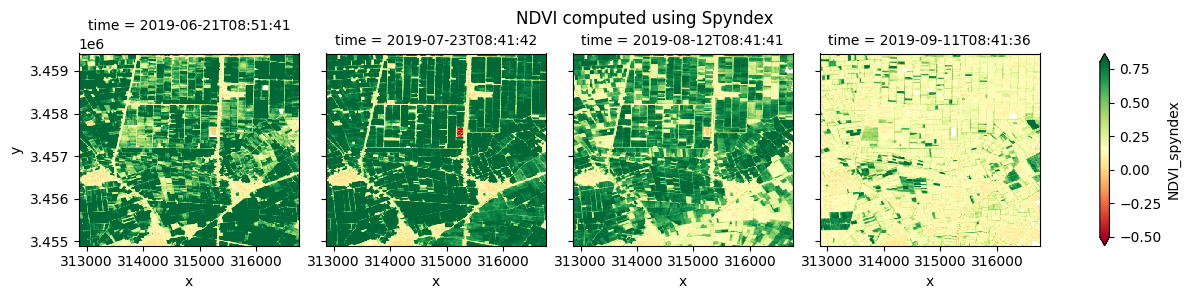

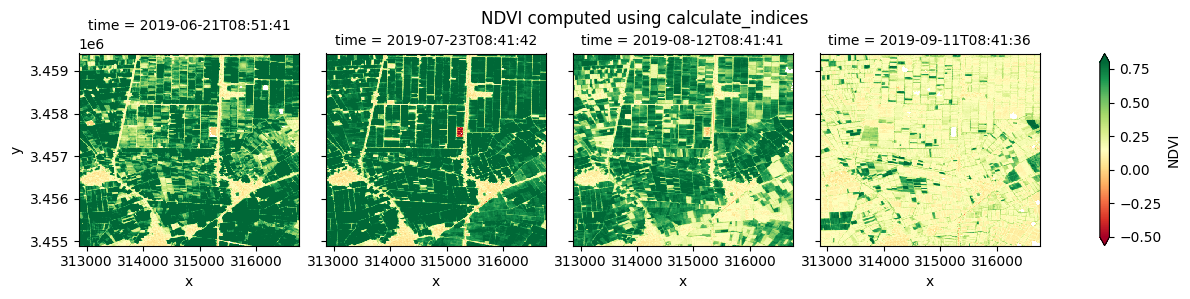

In [12]:
fig_1 = ds.NDVI_spyndex.plot(col="time", vmin=-0.50, vmax=0.8, cmap="RdYlGn")
fig_1.fig.suptitle("NDVI computed using Spyndex")

fig_2 = ds.NDVI.plot(col="time", vmin=-0.50, vmax=0.8, cmap="RdYlGn")
fig_2.fig.suptitle("NDVI computed using calculate_indices")

plt.show()

### Calculate Enhanced Vegetation Index (EVI) using spyndex

Using `spyndex.indices[indexName]` gives the detail parameter of the Spectral Index being used.
The cell below print out the information concerning the `EVI` Spectral Index.

In [13]:
print(spyndex.indices["EVI"])

EVI: Enhanced Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['g', 'N', 'R', 'C1', 'C2', 'B', 'L']
        * Formula: g*(N-R)/(N+C1*R-C2*B+L)
        * Reference: https://doi.org/10.1016/S0034-4257(96)00112-5
        


### Compute the EVI index using the `spectral computeIndex` method.

From the above indices `EVI` has constant values for its computation. 


Spyndex fucntion provides the constant values which can also be overwritten. The [constants](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/constants.json) can be accessed using `spyndex.constants` as shown below.

In [14]:
ds["EVI_spyndex"] = spyndex.computeIndex(
    index=["EVI"],
    params={
        "C1": spyndex.constants["C1"].value,
        "C2": spyndex.constants["C2"].value,
        "g": spyndex.constants["g"].value,
        "L": spyndex.constants["L"].value,
        "N": ds.nir,
        "R": ds.red,
        "B": ds.blue,
    },
)

### Compute EVI using the `calculate indices` function.
Using DE Africa `calculate_indices` to calculate the EVI spectral index.

In [15]:
ds = calculate_indices(ds, index=["EVI"], satellite_mission='s2')

### Plot the EVI results.
The comparison plot below shows that EVI from calculate_indices compared with EVI calculated using the Spyndex package. We can see there is a difference in scale as the Spyndex values range from -`2,000` to `2,000`. There is also not much contrast in the Spyndex values. 

Why is there a difference in EVI values when they are calculated using the same formula?

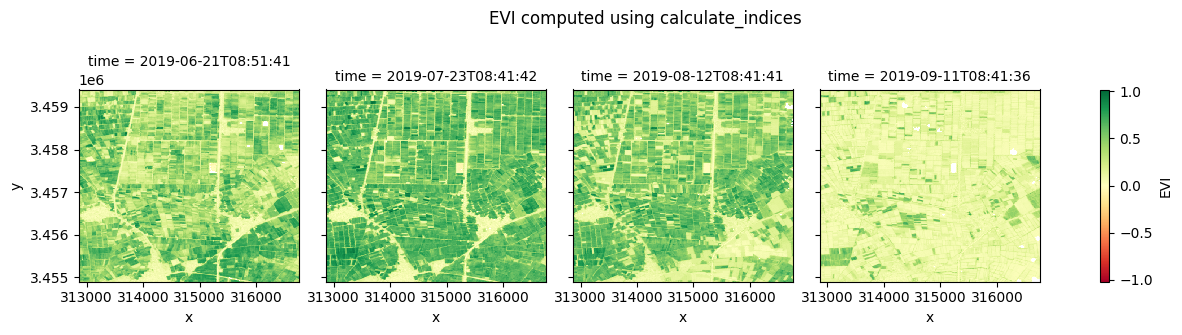

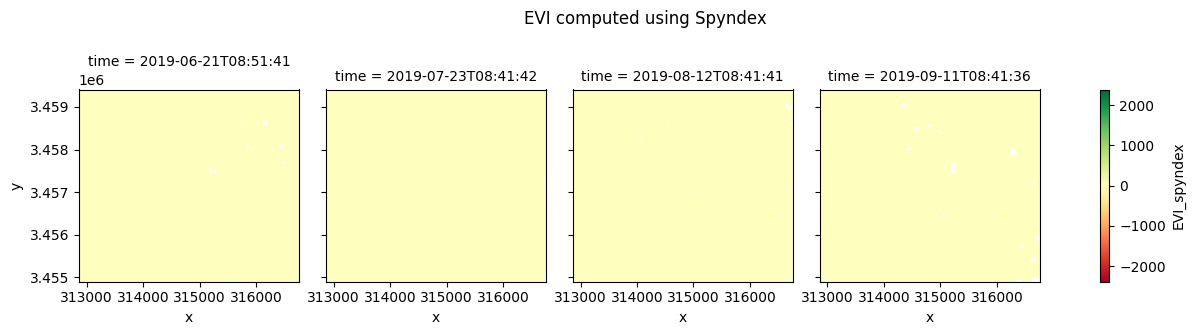

In [16]:
fig_3 = ds.EVI.plot(col="time", cmap="RdYlGn")
fig_3.fig.suptitle("EVI computed using calculate_indices", y= 1.1)

fig_4 = ds.EVI_spyndex.plot(col="time", cmap="RdYlGn")
fig_4.fig.suptitle("EVI computed using Spyndex", y= 1.1);

plt.show()

### Normalisation

The reason for the difference in EVI values is normalisation. The `calculate_indices` function normalises Sentinel-2 values according to a maximum surface reflectance value of `10,000`. We can adapt the Spyndex calculation, as below, to match this normalisation procedure.

We can also clip the image values using `clip()`. The EVI generally ranges from `-1` to `1`, so w

In [17]:
ds["EVI_spyndex"] = spyndex.computeIndex(
    index=["EVI"],
    params={
        "C1": spyndex.constants["C1"].value,
        "C2": spyndex.constants["C2"].value,
        "g": spyndex.constants["g"].value,
        "L": spyndex.constants["L"].value,
        "N": ds.nir/10000,
        "R": ds.red/10000,
        "B": ds.blue/10000,
    },
)

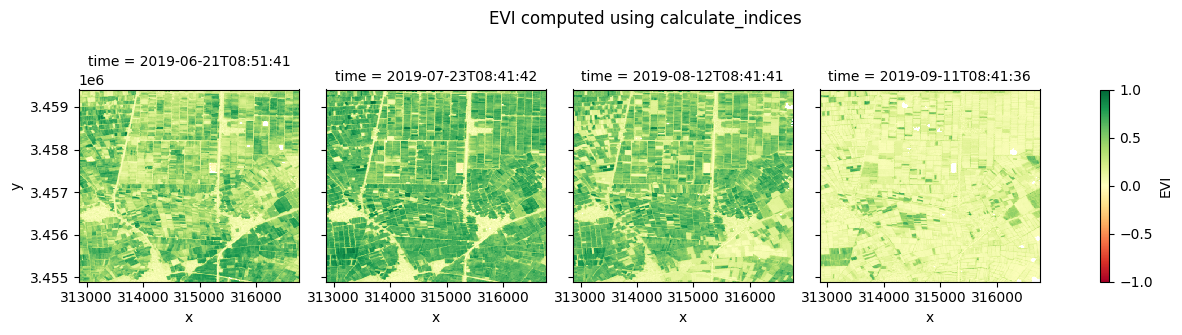

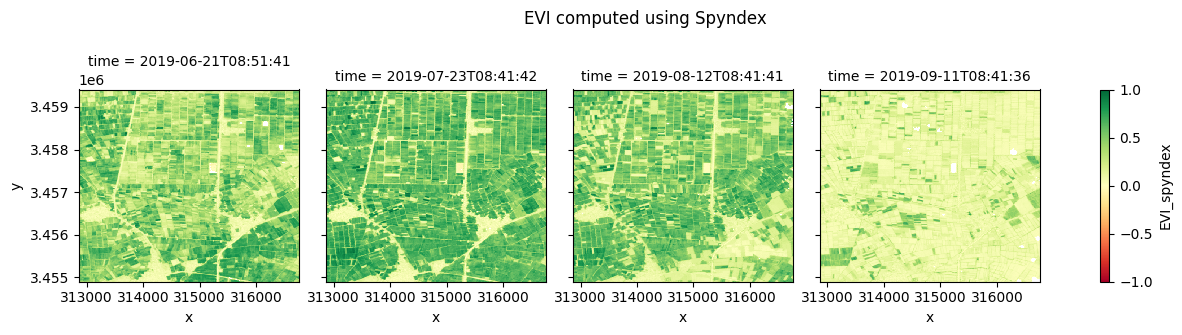

In [18]:
fig_5 = ds.EVI.clip(-1,1).plot(col="time", cmap="RdYlGn")
fig_5.fig.suptitle("EVI computed using calculate_indices", y= 1.1)

fig_6 = ds.EVI_spyndex.clip(-1,1).plot(col="time", cmap="RdYlGn")
fig_6.fig.suptitle("EVI computed using Spyndex", y= 1.1);

plt.show()

We can see that the values now match, and that there is more contrast in the images with clipped values.

Spyndex has more indices within its packages, the cells below will touch some of the indices.  The focus will be on the `GNDVI` and `CIG` among the rest.
There are [232 indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/spectral-indices-table.csv).

#### Green Normalized Difference Vegetation Index (GNDVI)

The Green Normalized Difference Vegetation Index [GNDVI](https://pro.arcgis.com/en/pro-app/latest/arcpy/image-analyst/gnvdi.htm#:~:text=The%20Green%20Normalized%20Difference%20Vegetation%20Index%20(GNDVI)%20method%20is%20a,uptake%20into%20the%20plant%20canopy.) is a vegetation index for estimating photo synthetic activity and is a commonly used to determine water and nitrogen uptake into the plant canopy.
GNDVI is more sensitive to chlorophyll variation in the crop and has a higher saturation point. It can be used in crops with dense canopies or in more advanced stages of development. More information can be found in the Reference in the cell below.

#### Viewing the attributes of the GNDVI

In [19]:
print(spyndex.indices["GNDVI"])

GNDVI: Green Normalized Difference Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'G']
        * Formula: (N-G)/(N+G)
        * Reference: https://doi.org/10.1016/S0034-4257(96)00072-7
        


#### Calculate GNDVI using spyndex

In [20]:
ds["GNDVI_spyndex"] = spyndex.computeIndex(
    index=["GNDVI"], 
    params={
        "N": ds.nir, 
        "G": ds.green
    }
)

#### Plot the GNDVI results

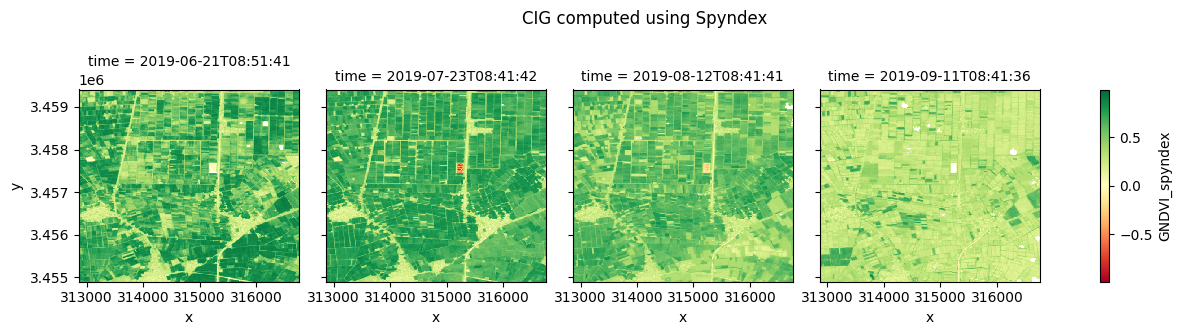

In [21]:
fig_7 = ds.GNDVI_spyndex.plot(col="time", cmap="RdYlGn")
fig_7.fig.suptitle("CIG computed using Spyndex", y= 1.1)
plt.show()

### Visible Atmospherically Resistant Index (VARI)

The Visible Atmospherically Resistant Index [VARI](https://pro.arcgis.com/en/pro-app/latest/arcpy/image-analyst/vari.htm) is a vegetation index for estimating vegetation fraction quantitatively with only the visible range of the spectrum. More information can be found in the Reference in the cell below.

### Viewing the attributes of the VARI

In [22]:
print(spyndex.indices["VARI"])

VARI: Visible Atmospherically Resistant Index
        * Application Domain: vegetation
        * Bands/Parameters: ['G', 'R', 'B']
        * Formula: (G-R)/(G+R-B)
        * Reference: https://doi.org/10.1016/S0034-4257(01)00289-9
        


In [23]:
ds["VARI_spyndex"] = spyndex.computeIndex(
    index=["VARI"], 
    params={
        "B": ds.blue, 
        "G": ds.green,
        "R": ds.red
    }
)

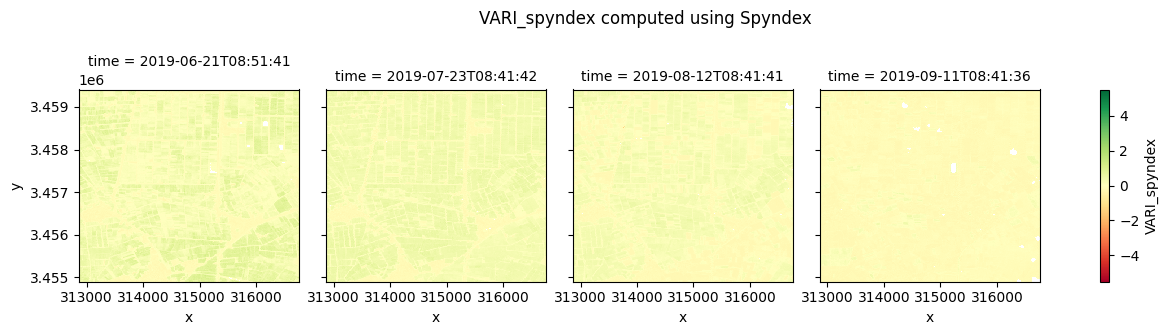

In [24]:
fig_8 = ds.VARI_spyndex.plot(col="time", cmap="RdYlGn")
fig_8.fig.suptitle("VARI_spyndex computed using Spyndex", y= 1.1)
plt.show()

## Conclusion

This notebook demonstrates how the `Spyndex package` can be used with DE Africa datasets to compute Spectral Indices. There are [232 optical and radar](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/spectral-indices-table.csv) indices available through the package, try it out and modify the notebook to test different indices and their results.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [25]:
print(datacube.__version__)

1.8.13


**Last Tested:**

In [26]:
from datetime import date
print(date.today())

2023-06-18
